# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Write-a-function-to-construct-the-conditional-probability-matrix-of-input-data-points" data-toc-modified-id="Write-a-function-to-construct-the-conditional-probability-matrix-of-input-data-points-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Write a function to construct the conditional probability matrix of input data points</a></div>

In [1]:
import pandas as pd
import numpy as np
import scipy

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14


# Write a function to construct the conditional probability matrix of input data points

In [ ]:
class TSNE():
    
    def _init_(self, X):
        self.X = X
    
    def sigma(self, S):
        if len(S) != 

In [2]:
def d(xi, xj, sigma_i):
    """The exponent for the probability function"""
    return -np.sum((xi - xj)**2)/(2*sigma_i**2)

def Z_i(i, X, S):
    """
    Computes the normalization factor for p_ij
    """
    # normalization factor:
    exp_ij = 0
    d_ij = 0
    sigma_i = S[i]
    x_i = X[:, i]
    for j in np.arange(X.shape[1]):
        if i == j:
            continue
        
        x_j = X[:, j]
        d_ij = d(x_i, x_j, sigma_i)
        exp_ij += np.exp(d_ij)
            
    return exp_ij

def non_norm_p_j_given_i(i, j, X, S):
    """Non-normalized p_i|j"""
    sigma_i = S[i]
    x_i = X[:, i]
    x_j = X[:, j]
    d_ij = d(x_i, x_j, sigma_i)
    exp_ij = np.exp(d_ij)
    return exp_ij

def norm_p_j_given_i(i, j, X, S):
    """Normalized p_i|j"""
    if i == j:
        return 0
    else:
        return non_norm_p_j_given_i(i, j, X, S)/Z_i(i, X, S)

In [3]:
x1 = np.linspace(0, 10, 100) + np.random.normal(0, 2, 100)
x2 = np.linspace(0, 10, 100) + np.random.normal(0, 2, 100)
x3 = np.random.normal(5, 2, 100)
x4 = np.random.normal(5, 3, 100)

X = np.vstack((x1, x2, x3, x4)).T
S = np.array([2, 2, 2, 2])

In [4]:
P = np.zeros((X.shape[1], X.shape[1]))

In [5]:
for i in range(X.shape[1]):
    for j in range(X.shape[1]):
        P[i, j] = norm_p_j_given_i(i, j, X, S)

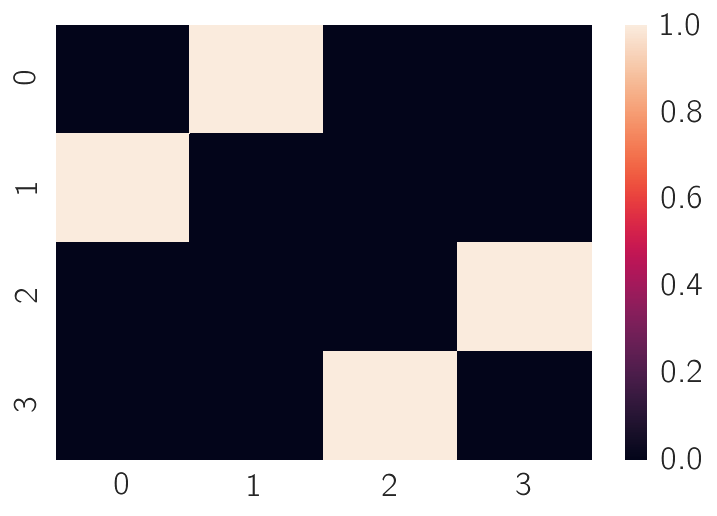

In [6]:
sns.heatmap(P)

In [130]:
def binary_search(T, array):
    L = 0
    R = len(array) - 1
    
    def search(L, R):
        if L > R:
            return L

        m = np.int(np.floor((L+R)/2))
        close = np.isclose(array[m], T, atol=10**-3)

        if close:
            return m

        if array[m] < T:
            L = m + 1
        elif array[m] > T:
            R = m - 1

        if L > R:
            return L
        
        if m == len(array) - 1:
            return m
        if m == 0:
            return 0
    
        return search(L, R)
    
    m = search(L, R)
    return m

In [111]:
def shannon(i, X, S):
    """Shannon Entropy of p_j|i"""
    H = 0
    Z = Z_i(i, X, S)

    for j in range(X.shape[1]):
        # calculate p_ij
        p_ji = norm_p_j_given_i(i, j, X, S)
        # smart approximation to log_pij to avoid log2(0)
        log_pji = d(X[:,i], X[:, j], S[i]) - np.log(Z)
        log_pji = log_pji/np.log(2)
        # shannon entropy
        H += -p_ji*log_pji

    return H

In [127]:
def make_sigma_array(s_min, s_max, n, S, i):
    s = np.logspace(np.log10(s_min), np.log10(s_max), n)
    H_array = np.empty(n)
    
    for k, sigma_i in enumerate(s):
        S[i] = sigma_i
        H_array[k] = shannon(i, X, S)
    
    return s, H_array

def set_sigma(perplexity, X, S_in):
    S = S_in
    if perplexity > X.shape[1]:
        print('Perplexity is above allowable limits. Resetting to maximum possible value.')
        perplexity = X.shape[1]-1

    def search_all(S):
        for i in range(X.shape[1]):
            s, H_array = make_sigma_array(30, 100, 1000, S_in, i)
            index = binary_search(np.log2(perplexity), H_array)
            S[i] = s[index]
        return S
    
    changing = True
    S = search_all(S_in)
    return S

In [113]:
s, H_array = make_sigma_array(30, 100, 1000, S, 1)

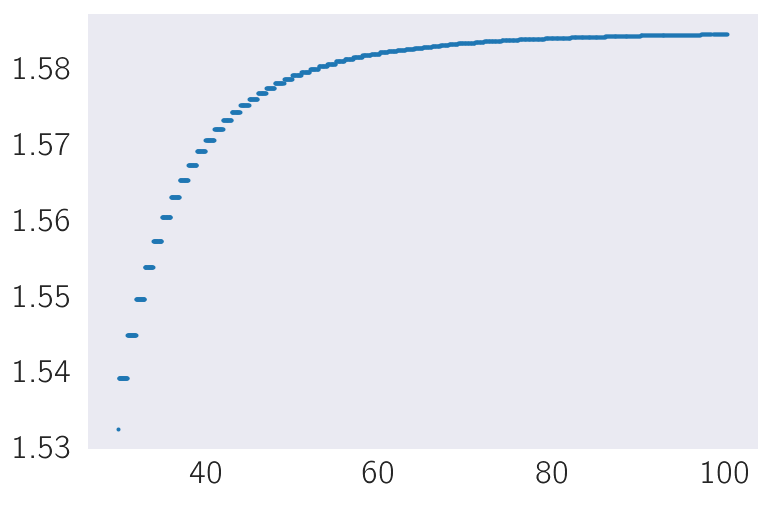

In [114]:
plt.plot(s, H_array, 'o', ms=2)

In [131]:
S = set_sigma(10, X, S_in=S)

Perplexity is above allowable limits. Resetting to maximum possible value.


In [132]:
print(S)

[96 86 54 73]


In [107]:
def grad_i(i, X, Y, S):
    grad = 0
    for j in np.arange(X.shape[1]):
        p_ji = norm_p_j_given_i(i, j, X, S)
        p_ij = norm_p_j_given_i(j, i, X, S)
        q_ji = norm_p_j_given_i(i, j, Y, Sy)
        q_ij = norm_p_j_given_i(j, i, Y, Sy)
        
        grad += (p_ji + p_ij - q_ji - q_ij)*(Y[:, i] - Y[:, j])
    
    return 2*grad

def grad_descent(n, a, X, Y, S):
    
    for i in np.arange(X.shape[1]):
        y_i_new = Y[:, i] + n*grad_i(i, X, Y, S) + a*(Y[:, i])